In [1]:
#Import Turing, Distributions, LinearAlgebra and DataFrames
using Turing, Distributions, LinearAlgebra, DataFrames

# Import MCMCChain, Plots, StatsPlots, GraphPlot, GraphRecipes, PyCall and Statistics for visualizations and diagnostics.
using MCMCChains, Plots, StatsPlots, GraphPlot, GraphRecipes, PyCall, Statistics

# Set a seed for reproducibility.
using Random
Random.seed!(12);

# Turn off progress monitor.
Turing.turnprogress(false)

┌ Info: Recompiling stale cache file /home/saumya/.julia/compiled/v1.1/Turing/gm4QC.ji for Turing [fce5fe82-541a-59a6-adf8-730c64b5f9a0]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file /home/saumya/.julia/compiled/v1.1/Plots/ld3vC.ji for Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file /home/saumya/.julia/compiled/v1.1/StatsPlots/SiylL.ji for StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file /home/saumya/.julia/compiled/v1.1/GraphPlot/bUwXr.ji for GraphPlot [a2cc645c-3eea-5389-862e-a155d0052231]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file /home/saumya/.julia/compiled/v1.1/GraphRecipes/7oEYB.ji for GraphRecipes [bd48cda9-67a9-57be-86fa-5b3c104eda73]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file /home/saumya/.julia/compiled/v1.1/PyCall/GkzkC.ji for PyCall [438e738f-606a-5dbb-bf0a-cddfbfd45ab0]
└ @ Base loading.jl:1184
┌ In

false

In [2]:
# Set hyperparameters- K is the number of clusters and eta is the probability matrix between clusters 
K = 2
alpha = 0.1 * ones(K)
eta = Symmetric(rand(K,K))
eta

2×2 Symmetric{Float64,Array{Float64,2}}:
 0.25851   0.474177
 0.474177  0.434506

┌ Info: Recompiling stale cache file /home/saumya/.julia/compiled/v1.1/PyPlot/oatAj.ji for PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1184


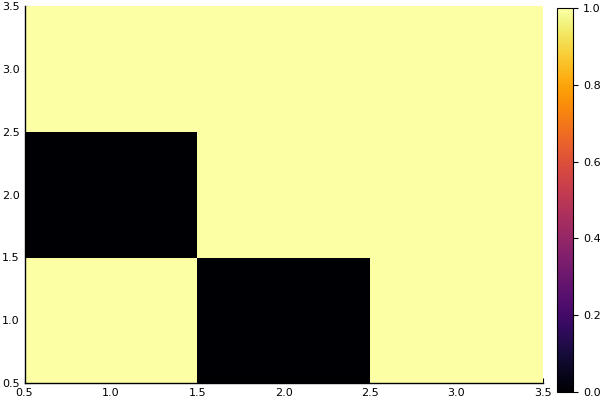

In [3]:
# Generate data using randomly generated cluster assignments
N = 3
clusters = rand(1:K, N)
graph = zeros(N,N)
for i=1:N
    graph[i, i] = 1
    for j = 1:i-1
        cluster_i = clusters[i]
        cluster_j = clusters[j]
        eta_ij = eta[cluster_i, cluster_j]
        if(rand(Binomial(1,eta_ij), 1)[1] == 1)
            graph[i, j] = 1
            graph[j, i] = 1
        end
    end
end
pyplot()
heatmap(graph)

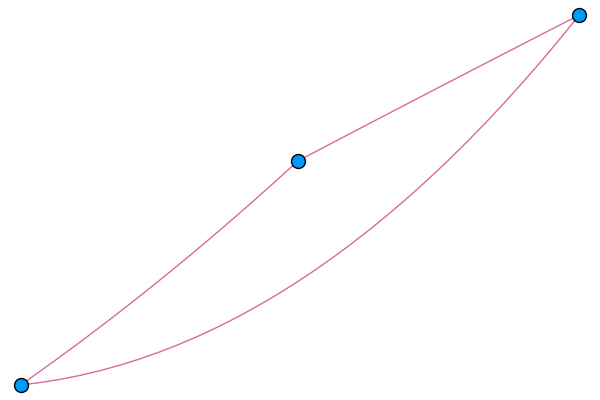

In [17]:
graphplot(graph, markersize = 10)

In [5]:
# Define the model
@model mmsb(alpha, eta, graph, N) = begin
    pi = Vector{Vector}(undef, N)
    for n=1:N
        pi[n] ~ Dirichlet(alpha)
    end
    
    for n=1:N
        for m=1:n-1
            val = max((pi[n])'*eta*pi[m], 0)
            graph[n, m] ~ Bernoulli(val)
        end
    end
end;

In [6]:
# This is temporary while the reverse differentiation backend is being improved.
Turing.setadbackend(:forward_diff)

chain = sample(mmsb(alpha, eta, graph, N), HMC(50000, 0.01, 10) )

[HMC] Finished with
  Running time        = 30.7518901310001;
  Accept rate         = 1.0;
  #lf / sample        = 9.9998;
  #evals / sample     = 2.0e-5;
  pre-cond. metric    = [1.0].


Object of type Chains, with data of type 50000×12×1 Array{Union{Missing, Float64},3}

Log evidence      = 0.0
Iterations        = 1:50000
Thinning interval = 1
Chains            = 1
Samples per chain = 50000
internals         = elapsed, epsilon, eval_num, lf_eps, lf_num, lp
parameters        = pi[3][2], pi[2][1], pi[2][2], pi[1][2], pi[3][1], pi[1][1]

2-element Array{ChainDataFrame,1}

Summary Statistics
. Omitted printing of 1 columns
│ Row │ parameters │ mean      │ std      │ naive_se   │ mcse      │ ess     │
│     │ Symbol     │ Float64   │ Float64  │ Float64    │ Float64   │ Any     │
├─────┼────────────┼───────────┼──────────┼────────────┼───────────┼─────────┤
│ 1   │ pi[1][1]   │ 0.0969138 │ 0.247626 │ 0.00110742 │ 0.0110198 │ 200.803 │
│ 2   │ pi[1][2]   │ 0.903086  │ 0.247626 │ 0.00110742 │ 0.0110198 │ 200.803 │
│ 3   │ pi[2][1]   │ 0.188242  │ 0.338273 │ 0.0015128  │ 0.0150702 │ 200.803 │
│ 4   │ pi[2][2]   │ 0.811758  │ 0.338273 │ 0.0015128  │ 0.0150702 │ 200.803 │
│ 5   

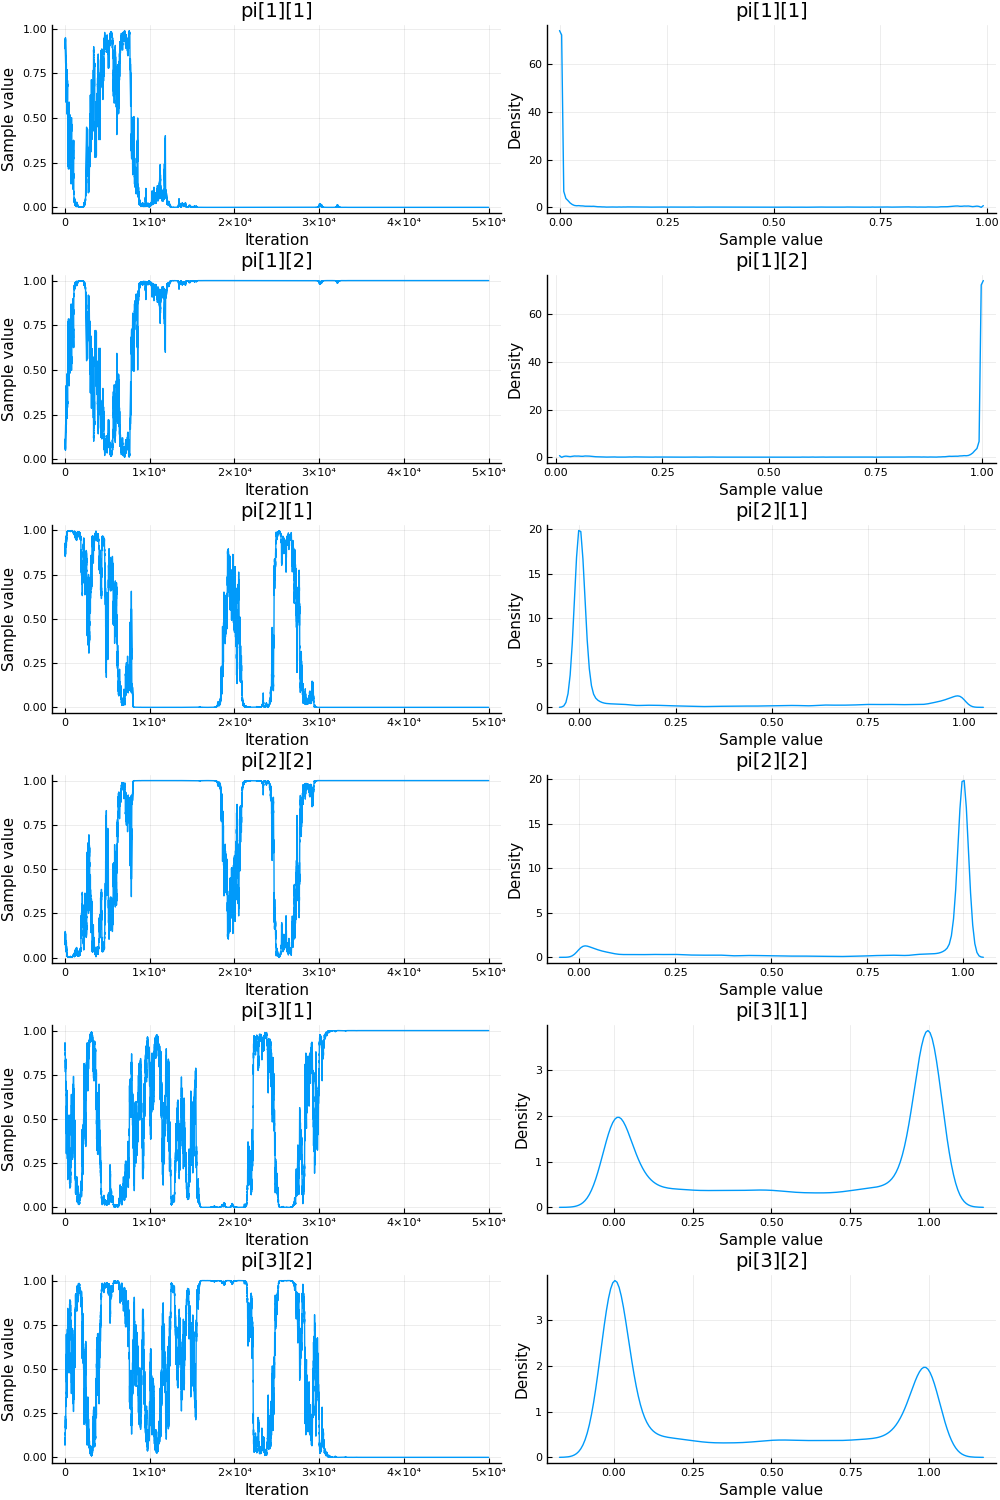

In [7]:
plot(chain)

┌ Warning: `colwise(f, d::AbstractDataFrame)` is deprecated, use `[f(col) for col = eachcol(d)]` instead.
│   caller = top-level scope at In[8]:4
└ @ Core In[8]:4


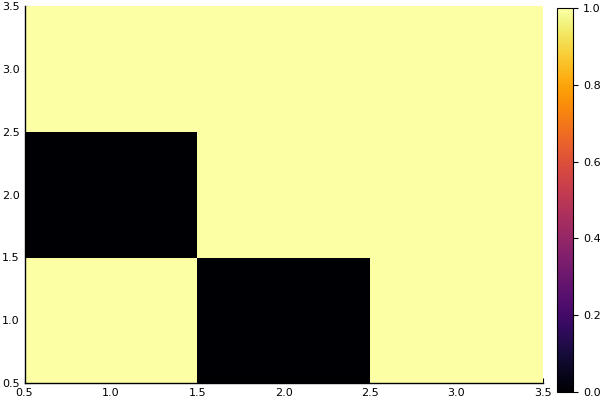

In [8]:
# Find the predicted clusters using the new parameters
clusters_pred = Array{Int64}(undef, N)
df = DataFrame(chain[:pi])
means = colwise(mean, df)
count = 1
i = 1

#Finding the index of the max value in each interval of size K (which represents the probabilities for each node) to get the predicted cluster assignments
maximum = means[1]
for mean in means
    if(mean >= maximum)
        clusters_pred[i] = count
        maximum = mean
    end
    count += 1
    if(count == K + 1)
        count = 1
        maximum = -Inf
        i += 1
    end
end

#Reconstructing the predicted graph using predicted cluster assignments
graph_pred = zeros(N,N)
for i=1:N
    graph_pred[i, i] = 1
    for j = 1:i-1
        cluster_i = clusters_pred[i] 
        cluster_j = clusters_pred[j]
        eta_ij = eta[cluster_i, cluster_j]
        if(rand(Binomial(1,eta_ij), 1)[1] == 1)
            graph_pred[i, j] = 1
            graph_pred[j, i] = 1
        end
    end
end
heatmap(graph_pred)

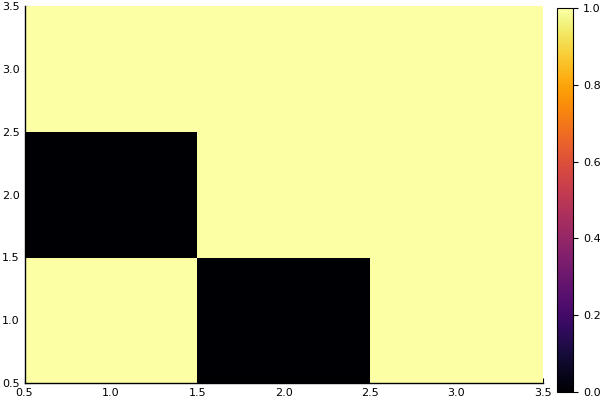

In [9]:
heatmap(graph)

In [10]:
graph_diff = graph - graph_pred
non_zero = 0
for row in graph_diff
    for ele in row
        if(ele != 0)
            non_zero += 1
        end
    end
end
println("The number of mismatches is ", non_zero)

The number of mismatches is 0
